# EDA

Criando arquivo com principais dependências e instalando.

In [2]:
%%writefile requirements.txt

pandas==1.5.3
numpy==1.26.1
boto3==1.33.4
pyarrow==13.0.0
fastparquet==2023.10.1

Writing requirements.txt


In [3]:
%pip install -r requirements.txt

                                              0.0/15.8 MB ? eta -:--:--
     --                                       0.9/15.8 MB 18.5 MB/s eta 0:00:01
     -----                                    2.1/15.8 MB 22.5 MB/s eta 0:00:01
     --------                                 3.4/15.8 MB 24.3 MB/s eta 0:00:01
     -----------                              4.7/15.8 MB 25.0 MB/s eta 0:00:01
     --------------                           5.8/15.8 MB 24.9 MB/s eta 0:00:01
     -----------------                        7.0/15.8 MB 25.0 MB/s eta 0:00:01
     ---------------------                    8.5/15.8 MB 26.0 MB/s eta 0:00:01
     ------------------------                10.1/15.8 MB 27.0 MB/s eta 0:00:01
     ----------------------------            11.7/15.8 MB 29.7 MB/s eta 0:00:01
     --------------------------------        13.4/15.8 MB 29.7 MB/s eta 0:00:01
     ------------------------------------    14.9/15.8 MB 31.1 MB/s eta 0:00:01
     --------------------------------------  15.

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
explainerdashboard 0.4.2.2 requires numpy<=1.23, but you have numpy 1.26.1 which is incompatible.
numba 0.57.0 requires numpy<1.25,>=1.21, but you have numpy 1.26.1 which is incompatible.
pycaret 3.0.2 requires numpy<1.24,>=1.21, but you have numpy 1.26.1 which is incompatible.
sktime 0.17.0 requires numpy<1.25,>=1.21.0, but you have numpy 1.26.1 which is incompatible.
ydata-profiling 4.2.0 requires numpy<1.24,>=1.16.0, but you have numpy 1.26.1 which is incompatible.

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import requests
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
import warnings
import boto3
warnings.filterwarnings("ignore", 'This pattern has match groups')

Definindo variável flag que busca dados de fontes diferentes (AWS S3 ou [Group Lens](https://grouplens.org/)):

In [5]:
ENV_AWS = False

### Buscando dataset do AWS S3 ou Group Lens

In [6]:
def download():
    filename = "ml-25m.zip"
    url = f"https://files.grouplens.org/datasets/movielens/{filename}"
    query_parameters = {"downloadformat": "zip"}
    
    if not os.path.exists(f'{filename}'):
        response = requests.get(url, params=query_parameters)
        with open(filename, mode="wb") as file:
            file.write(response.content)

        with zipfile.ZipFile(filename,"r") as zip_ref:
            zip_ref.extractall()

def to_parquet():
    folder = "ml-25m"
    pd.read_csv(f"{folder}/movies.csv").to_parquet("movies.parquet")
    pd.read_csv(f"{folder}/ratings.csv").to_parquet("ratings.parquet")
    pd.read_csv(f"{folder}/tags.csv").to_parquet("tags.parquet")

In [7]:
if not ENV_AWS:
    download()
    to_parquet()

In [8]:
if ENV_AWS:
    s3 = boto3.client("s3")

    s3.download_file(
        Bucket="cdd-rawdata",
        Key="movies.parquet",
        Filename="movies.parquet",
    )
    
    s3.download_file(
        Bucket="cdd-rawdata",
        Key="ratings.parquet",
        Filename="ratings.parquet",
    )
    
    s3.download_file(
        Bucket="cdd-rawdata",
        Key="tags.parquet",
        Filename="tags.parquet",
    )

# Análise de Dados e Insights

## Movies
| Coluna | Tipo | Descrição |
| --- | --- | --- |
| movieId | int64 | ID único do Filme |
| title | object | Título e ano de lançamento do filme |
| genres | object | Generos do filme separados por "\|" |

In [9]:
df_movies = pd.read_parquet("movies.parquet")
df_movies.shape

(62423, 3)

In [10]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [11]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [12]:
df_movies.genres.nunique()

1639

### Criando coluna de Ano

In [13]:
df_movies['ano'] = df_movies.title.str[-7:].apply(lambda st: st[st.find("(")+1:st.find(")")])
df_movies.tail()

,movieId,title,genres,ano
62418,209157,We (2018),Drama,2018
62419,209159,Window of the Soul (2001),Documentary,2001
62420,209163,Bad Poems (2018),Comedy|Drama,2018
62421,209169,A Girl Thing (2001),(no genres listed),2001
62422,209171,Women of Devil's Island (1962),Action|Adventure|Drama,1962


In [14]:
df_movies = df_movies[pd.to_numeric(df_movies['ano'], errors='coerce').notnull()]

In [15]:
df_movies.ano = df_movies.ano.astype('int32')

In [16]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62013 entries, 0 to 62422
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62013 non-null  int64 
 1   title    62013 non-null  object
 2   genres   62013 non-null  object
 3   ano      62013 non-null  int32 
dtypes: int32(1), int64(1), object(2)
memory usage: 2.1+ MB


In [17]:
df_movies.loc[df_movies["ano"] <1500, "ano"] = np.nan

In [18]:
df_movies[df_movies.index==40372]

,movieId,title,genres,ano
40372,159257,6A,(no genres listed),NaN


In [19]:
df_movies.ano.describe()

count    62012.000000
mean      1992.045265
std         25.364698
min       1874.000000
25%       1976.000000
50%       2002.000000
75%       2012.000000
max       2019.000000
Name: ano, dtype: float64

Text(0.5, 1.0, 'Filmes por Ano de Lançamento')

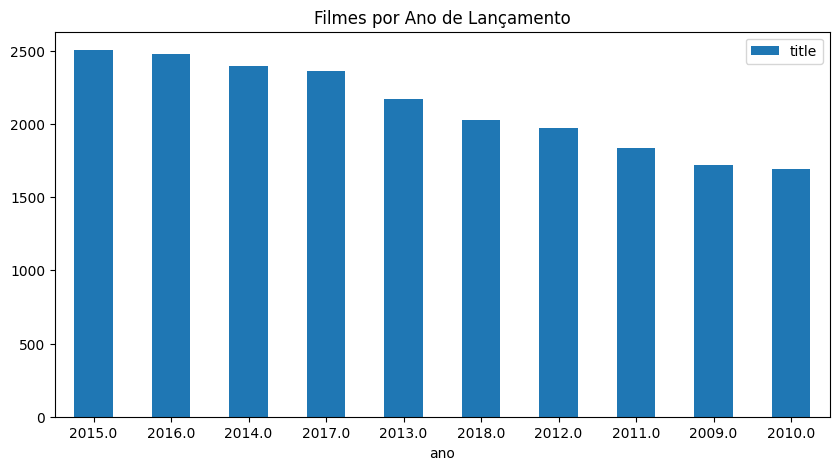

In [20]:
aux = df_movies.groupby(by=['ano']).title.nunique().reset_index()
ax = aux.sort_values(by='title', ascending=False).head(10)\
    .plot.bar(x='ano', y='title', rot=0, figsize=(10, 5))
plt.title('Filmes por Ano de Lançamento')

In [21]:
df_movies['ano'].value_counts()

2015.0    2513
2016.0    2488
2014.0    2406
2017.0    2374
2013.0    2173
          ... 
1883.0       1
1887.0       1
1874.0       1
1878.0       1
1880.0       1
Name: ano, Length: 135, dtype: int64

### Splitando generos e criando novas colunas

In [22]:
def split_genres(df_movies):
    aux = df_movies['genres'].str.count('\|').reset_index(drop=True)
    max_genres = aux.sort_values(ascending=False).reset_index(drop=True)[0]

    columns = []
    for i in range(max_genres+1):
        columns.append(f'genre_{i+1}')

    df_movies[columns] = df_movies['genres'].str.split('|', expand=True)
    return df_movies

In [23]:
df_movies = split_genres(df_movies)
df_movies.head(2)

,movieId,title,genres,ano,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7,genre_8,genre_9,genre_10
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0,Adventure,Animation,Children,Comedy,Fantasy,None,None,None,None,None
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995.0,Adventure,Children,Fantasy,None,None,None,None,None,None,None


#### Criando coluna de Total de Generos

In [24]:
df_movies['total_genres'] = df_movies['genres'].str.count('\|') + 1
df_movies.head(2)

,movieId,title,genres,ano,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7,genre_8,genre_9,genre_10,total_genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0,Adventure,Animation,Children,Comedy,Fantasy,None,None,None,None,None,5
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995.0,Adventure,Children,Fantasy,None,None,None,None,None,None,None,3


### Total de Generos por Filme

Text(0.5, 1.0, 'Qtd de Gêneros por Filme')

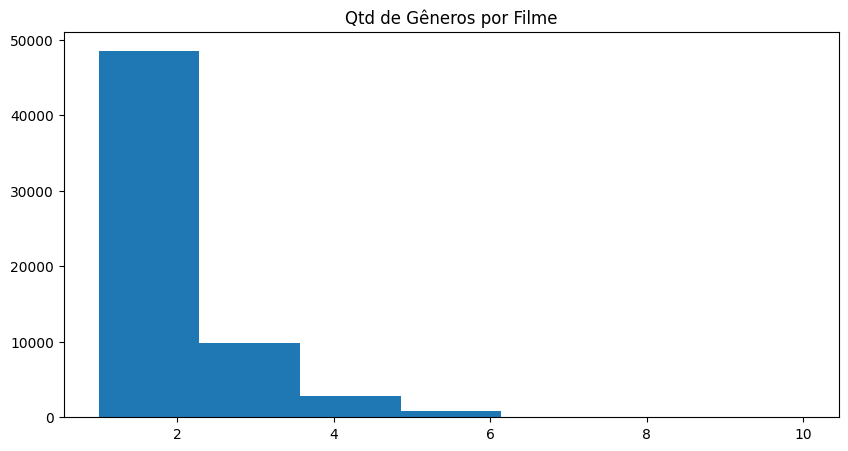

In [25]:
fig = plt.figure(figsize=(10,5))

plt.hist(df_movies['total_genres'], bins=7)
plt.title('Qtd de Gêneros por Filme')

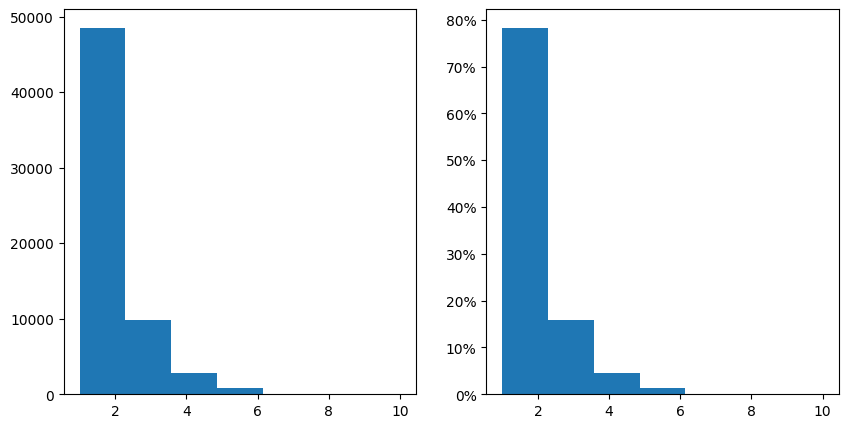

In [26]:
fig = plt.figure(figsize=(10,5))

#hist 1
fig.add_subplot(1,2,1)
plt.hist(df_movies['total_genres'], bins=7)

#hist 2
fig.add_subplot(1,2,2)
plt.hist(df_movies['total_genres'], weights=np.ones(len(df_movies['total_genres'])) / len(df_movies['total_genres']), bins=7)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))



plt.show()

### Contagem de frequência de genero por filme

In [27]:
#Criando lista com todos os gêneros distintos
genres = df_movies.T.values.tolist()[3:12][0]
genres = list(dict.fromkeys(genres))
print(genres)

[1995.0, 1994.0, 1996.0, 1976.0, 1992.0, 1988.0, 1967.0, 1993.0, 1964.0, 1977.0, 1965.0, 1982.0, 1990.0, 1991.0, 1989.0, 1937.0, 1940.0, 1969.0, 1981.0, 1973.0, 1970.0, 1960.0, 1955.0, 1959.0, 1968.0, 1980.0, 1975.0, 1986.0, 1948.0, 1943.0, 1950.0, 1946.0, 1987.0, 1997.0, 1974.0, 1956.0, 1958.0, 1949.0, 1972.0, 1998.0, 1933.0, 1952.0, 1951.0, 1957.0, 1961.0, 1954.0, 1934.0, 1944.0, 1963.0, 1942.0, 1941.0, 1953.0, 1939.0, 1947.0, 1945.0, 1938.0, 1935.0, 1936.0, 1926.0, 1932.0, 1985.0, 1979.0, 1971.0, 1978.0, 1966.0, 1962.0, 1983.0, 1984.0, 1931.0, 1922.0, 1999.0, 1927.0, 1929.0, 1930.0, 1928.0, 1925.0, 1914.0, 2000.0, 1919.0, 1923.0, 1920.0, 1918.0, 1921.0, 2001.0, 1924.0, 2002.0, 2003.0, 1915.0, 2004.0, 1916.0, 1917.0, 2005.0, 2006.0, 1902.0, 1903.0, 2007.0, 2008.0, 2009.0, 1912.0, 2010.0, 1913.0, 2011.0, 1898.0, 1899.0, 1894.0, 2012.0, 1910.0, 2013.0, 1896.0, 2014.0, 2015.0, 1895.0, 1909.0, 1911.0, 1900.0, 2016.0, 2017.0, 2018.0, 2019.0, 1905.0, 1904.0, 1891.0, 1892.0, 1908.0, 1897.0,

In [28]:
#Contando total de filmes por Gênero
df_genres_qtd = pd.DataFrame()
for g in genres:
    if g != None:
        df_aux = pd.DataFrame({'genre': [g],
                               'qtd': df_movies.groupby(['genres'])['genres'].apply(lambda x: x[x.str.contains(g)].count()).sum()})
        if df_genres_qtd.empty:
            df_genres_qtd = df_aux
        else:
            df_genres_qtd = pd.concat([df_genres_qtd, df_aux])
df_genres_qtd.head(3)

TypeError: first argument must be string or compiled pattern

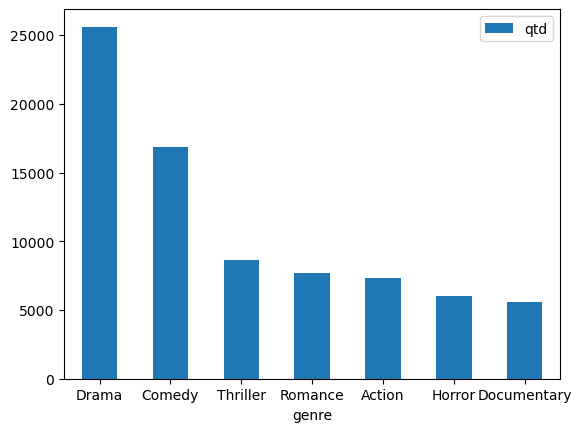

In [ ]:
ax = df_genres_qtd.sort_values(by='qtd', ascending=False).head(7).plot.bar(x='genre', y='qtd', rot=0)

## Ratings
| Coluna | Tipo | Descrição |
| :- | -: | :-: |
| userId | int64 | ID único do Usuário |
| movieId | int64 | ID único do Filme |
| rating | float64 | Nota de avaliação do usuário para o filme. As notas variam 0.5 pontos e estão no intervalo: [0.5, 5]. |
| timestamp | int64 | Marca temporal em que o usuário realizou a avaliação |

In [ ]:
df_ratings = pd.read_parquet("ratings.parquet")
df_ratings.shape

(25000095, 4)

In [ ]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [ ]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB


In [ ]:
df_ratings.rating.value_counts()

4.0    6639798
3.0    4896928
5.0    3612474
3.5    3177318
4.5    2200539
2.0    1640868
2.5    1262797
1.0     776815
1.5     399490
0.5     393068
Name: rating, dtype: int64

Text(0.5, 1.0, 'Freq Notas de Avaliações')

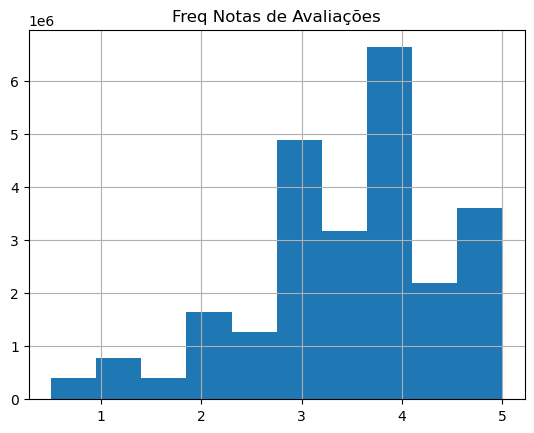

In [ ]:
df_ratings.rating.hist()
plt.title('Freq Notas de Avaliações')

In [ ]:
df_ratings['userId_ratings'] = df_ratings.groupby(by='userId').userId.transform('count')
df_ratings.head()

,userId,movieId,rating,timestamp,userId_ratings
0,1,296,5.0,1147880044,70
1,1,306,3.5,1147868817,70
2,1,307,5.0,1147868828,70
3,1,665,5.0,1147878820,70
4,1,899,3.5,1147868510,70


Text(0.5, 1.0, 'Quantidade de Avaliações por usuário')

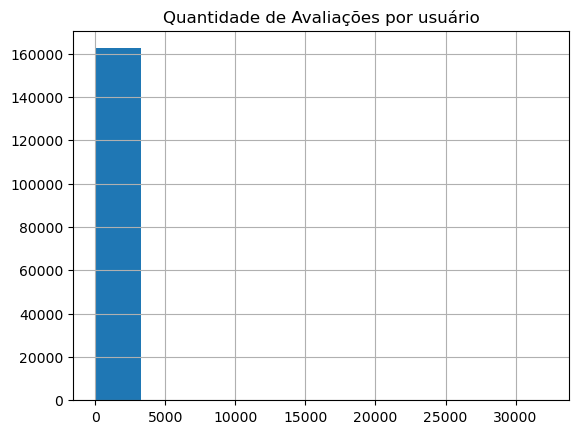

In [ ]:
df_ratings.drop_duplicates(subset=['userId']).userId_ratings.hist()
plt.title('Quantidade de Avaliações por usuário')

#### existem alguns usuários com um alto volume de avaliações (exemplo user com 32.2k de avaliações)

In [ ]:
aux = df_ratings.drop_duplicates(subset=['userId']).reset_index(drop=True)

In [ ]:
aux.userId_ratings.nunique()

2119

In [ ]:
aux.userId_ratings.sort_values(ascending=False)

72314     32202
80973      9178
137292     8913
33843      7919
20054      7488
          ...  
64554        20
64416        20
64425        20
50           20
80284        20
Name: userId_ratings, Length: 162541, dtype: int64

In [ ]:
df_agg = aux.groupby(by='userId_ratings').userId.nunique().reset_index()
df_agg.sort_values(by='userId', ascending=False).head(100)

,userId_ratings,userId
0,20,4611
1,21,3406
2,22,3112
3,23,2916
5,25,2740
...,...,...
94,114,418
96,116,410
101,121,406
100,120,405


In [ ]:
df_agg = aux.groupby(by='userId_ratings').userId.nunique().reset_index()
df_agg.sort_values(by='userId', ascending=True).head(1000)

,userId_ratings,userId
1629,1742,1
1645,1767,1
1646,1768,1
1647,1771,1
1697,1876,1
...,...,...
1089,1112,4
1257,1284,4
1258,1285,4
796,816,4


Text(0.5, 1.0, 'Quantidade de Avaliações por usuário')

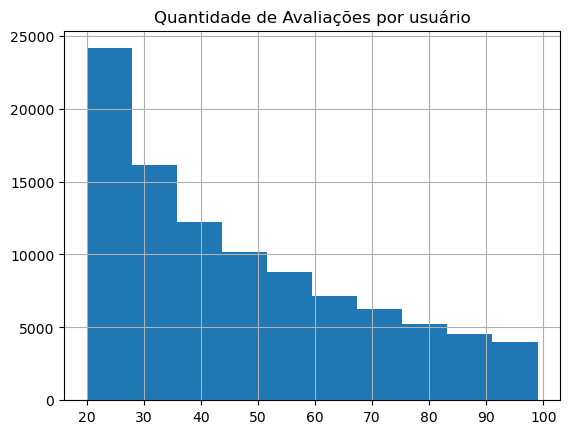

In [ ]:
aux = df_ratings.drop_duplicates(subset=['userId'])
aux[aux['userId_ratings']<100].userId_ratings.hist()

plt.title('Quantidade de Avaliações por usuário')

### Outro dado interessante é que na base de avaliações o mínimo de avaliações realizadas por usuário é de 20

In [ ]:
df_agg = aux.groupby(by='userId_ratings').userId.nunique().reset_index()
df_agg.sort_values(by='userId_ratings', ascending=True).head(1000)

,userId_ratings,userId
0,20,4611
1,21,3406
2,22,3112
3,23,2916
4,24,2599
...,...,...
995,1017,4
996,1018,7
997,1019,2
998,1020,6


## Tags
| Coluna | Tipo | Descrição |
| :- | -: | :-: |
| userId | int64 | ID único do Usuário |
| movieId | int64 | ID único do Filme |
| tag | object | Nota de avaliação do usuário para o filme. As notas variam 0.5 pontos e estão no intervalo: [0.5, 5]. |
| timestamp | int64 | Marca temporal em que o usuário realizou a avaliação |

In [ ]:
df_tags = pd.read_parquet("tags.parquet")
df_tags.shape

(1093360, 4)

In [ ]:
df_tags.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [ ]:
df_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093360 entries, 0 to 1093359
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   userId     1093360 non-null  int64 
 1   movieId    1093360 non-null  int64 
 2   tag        1093344 non-null  object
 3   timestamp  1093360 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 33.4+ MB


In [ ]:
df_tags.tag.value_counts()

sci-fi               8330
atmospheric          6516
action               5907
comedy               5702
surreal              5326
                     ... 
Internet gambling       1
family flim             1
Washington State        1
crazy neighbor          1
religious zealots       1
Name: tag, Length: 73050, dtype: int64

In [ ]:
df_tags.tag.nunique()

73050